# Credit Card Fraud Detection

In this example, we'll use classification techniques from machine learning to detect potential cases of credit card fraud.

## Import all packages

These are the main packages we are going to work with:

* [s3fs](https://s3fs.readthedocs.io/en/latest/#) to download data from AWS S3 buckets;
* [Pandas](https://pandas.pydata.org) to manipulate tabular data structures;
* [Seaborn](https://seaborn.pydata.org/index.html) and [Matplotlib](https://matplotlib.org) for data visualization;
* [Scikit-Learn](https://scikit-learn.org/stable/) to build and evaluate regression models; and
* [Imbalanced-Learn](https://imbalanced-learn.org/dev/index.html) to oversample the dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

## Dataset

The dataset contains transactions made by credit cards in September 2013 by European cardholders. We can fetch the data directly from [Kaggle]https://www.kaggle.com/mlg-ulb/creditcardfraud); alternatively, we can get it from one of ...'s AWS S3 open buckets (no AWS credentials required).

In the following cell, we load the dataset directly from AWS using the URI `s3://.../creditcard.csv`.

In [2]:
records = pd.read_csv(
    "../DATA/creditcard.csv",
    # "s3://.../creditcard.csv"
)
records.drop('Time', axis=1, inplace=True)
print(records.head(1))
print(records.shape)

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.098698  0.363787  0.090794  ... -0.018307  0.277838 -0.110474  0.066928   

        V25       V26       V27       V28  Amount  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62      0  

[1 rows x 30 columns]
(284807, 30)


By default, the data is distributed to all available engines; that is, the rows of the DataFrame `records` are split into partitions and sent to each of the cores. This allows embarrassingly parallel algorithms—like computing sums—to scale with the data and resources at hand.

## Exploratory analysis

The dataset consists of 30 columns. To preserve user anonymity, the first 28 columns (`V1...V28`) result from a [Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis). The [Kaggle documentation for this dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) provides more details. Our goal here is to classify records using some features.

Before doing anything, it might be interesting to have a look at the raw data to understand it and see if we can extract some patterns. First, let's have a look at both fraudulent and normal transactions distributions.

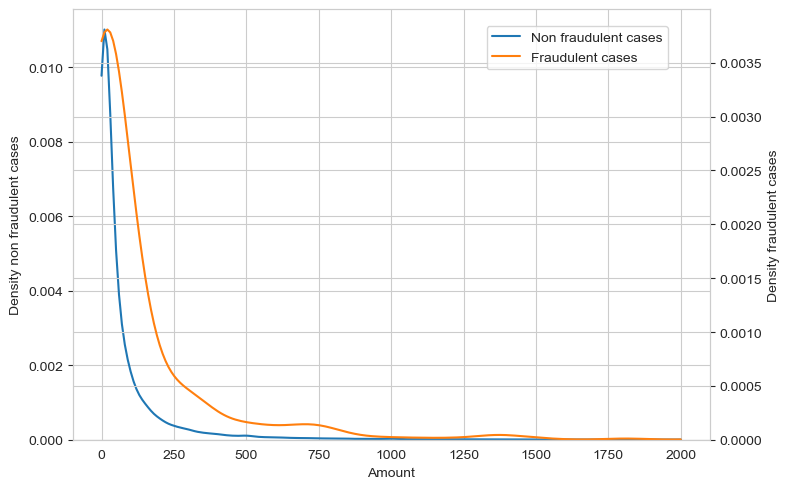

In [3]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.kdeplot(
    data=records[records.Class == 0], x="Amount",
    ax=ax, clip=[0, 2000], c='tab:blue', label="Non fraudulent cases")
ax.set(ylabel="Density non fraudulent cases")

ax2 = ax.twinx()
sns.kdeplot(
    data=records[records.Class == 1], x="Amount",
    ax=ax2, clip=[0, 2000], c='tab:orange', label="Fraudulent cases"
)
ax2.set(ylabel="Density fraudulent cases")

fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.95))
fig.tight_layout()

It's interesting to see that the distributions are not identical. This indicates that the fraudulent behaviours deviate from normal/legitimate behaviours. While the median/mode are close for both fraudulent and normal transactions, the fraudulent transactions have 3 modes. These transactions are also generally larger.

In [4]:
nonfraud_cases = records[records.Class == 0]
fraud_cases = records[records.Class == 1]
nonfraud_count = len(nonfraud_cases)
fraud_count = len(fraud_cases)
fraud_percentage = round(fraud_count / nonfraud_count * 100, 2)
print(f"{fraud_percentage}% of cases are fraudulent\n\n")
print("Non-fraudulent cases\n", nonfraud_cases.Amount.describe())
print("\n\nFraudulent cases\n", fraud_cases.Amount.describe())

0.17% of cases are fraudulent


Non-fraudulent cases
 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


Fraudulent cases
 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


Observations:

* The distribution has significant outliers. The distribution is very skewed; we observe extrema several standard deviations away from most reasonable measures of centrality.
* The dataset is strongly unbalanced—only 0.17% of the records are fraudulent so the signal from fraudulent transactions is effectively swamped by legitimate ones. Mitigating imbalanced data is a known challenge in solving classification problems.

There are strategies to mitigate imbalanced data like sub-sampling to prevent overfitting, and choosing an appropriate metric.

### Scaling
The `Amount` column is the only one which is not scaled which is problematic for our analysis. We need to scale this column to remove bias from the model. Instantiating an object from the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class from Scikit-Learn's [`preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) submodule provides a way to effect this transformation accross the partitioned dataset.

In [5]:
amount = records['Amount'].values.reshape(-1, 1)
std_scaler = StandardScaler()
std_scaler.fit(amount)
records['Amount'] = std_scaler.transform(amount).flatten()

### Sub-sampling

Sub-sampling the dataset to get a balanced dataset—i.e., one with 50% fraudulent transactions—will prevent the model from overfitting. Otherwise, the model might learn to classify all records as non-fraudulent—that is, producing a constant-valued classifier—and it would be correct over 99% of the time.

In [6]:
# amount of fraud classes 492 rows.
fraud_df = records[records.Class == 1]

# non_fraud_df = records[records.Class == 0].sample(492)
non_fraud_df = records[records.Class == 0].head(492)

sub_records =  pd.concat([fraud_df, non_fraud_df], axis=0, ignore_index=True)

# Shuffle dataframe rows
sub_records = sub_records.sample(frac=1)

[Correlation matrices](https://nhigham.com/2020/04/14/what-is-a-correlation-matrix/) are often used to identify important features in matrices representing data. In this case, we also want to distinguish features that can be used to classify fraudulent cases. The parameters `V1`, $\ldots$, `V28` result from a Principal Component Analysis that maximizes variance in an abstract sense. We don't know how these numerical features relate to the original features nor how they relate to the remaining features that are not encoded.

In [7]:
corr = sub_records.corr()

In [8]:
corr_class = pd.DataFrame(corr["Class"])

# remove the Class itself from the correlation since it's 1
corr_class = corr_class.drop("Class", axis=0)

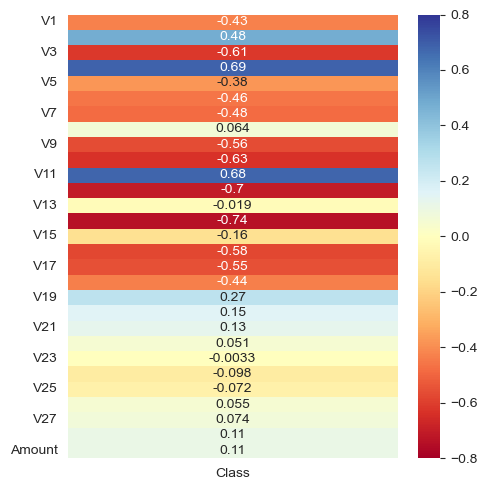

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(
    corr_class,
    annot=True,
    cmap="RdYlBu", center=0,
    vmin=-0.8, vmax=0.8,
    ax=ax
)

fig.tight_layout()

From this analysis, we observe that some features don't really correlate meaningfully with whether a record is fraudulent. Zero correlation indicates *no correlation*, $+1$ correlation indicates that the feature is *totally correlated/linked* to the output, and $-1$ correlation indicates strong *anti-correlation*. Then, for instance, given that the correlation of feature `V23` to the fraud class is $-0.0033$, it is not meaningfully correlated at all. Removing features like this can help the model to better discover meaningful patterns.

## Classifying fraudulent records

We can reasonably drop all features with a correlation value below $0.1$ (in absolute value) from the sub-sample. Once the weakly-correlated columns are dropped, we split the data into training & testing sets. Given that there are not many rows in the sub-sample, we'll use an $80\%/20\%$ ratio (as opposed to a more typical $70\%/30\%$ split when more data is available).

In [10]:
def data_preparation(sub_records):

    x = sub_records.drop('Class', axis=1)
    x.drop(["V8", "V13", "V15", "V22", "V23", "V25", "V26", "V27", "Amount"], axis=1)
    y = sub_records['Class']

    # cast classification variable to integer
    y = y.values.astype(np.int64)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = data_preparation(sub_records)

### Train a Random Forest Classifier

Next, having selected suitable features and having partitioned the rebalanced data into training & testing sets, we can train a classifier and evaluate the model using the testing dataset.

In [11]:
def prediction_model(x_train, x_test, y_train, y_test):

    print(x_train.shape, x_test.shape)
    
    model = RandomForestClassifier()
    #model = LogisticRegression()
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    
    return preds

preds = prediction_model(x_train, x_test, y_train, y_test)

(787, 29) (197, 29)


We'll define a helper function to gather a distributed dataframe from all engines onto the root engine. There are a number of distributed datasets we will apply this to below.

We'll apply this function first to the vector of targets from the testing data set—that is, `y_test`—that was previously distributed to all the engines. This permits us to apply standard Scikit-Learn reporting functions like [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) from [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics) to summarise the model's performance.

In [12]:
print(
    f"ROC AUC : {roc_auc_score(y_test, preds):.3f}\n\n"
    f"{classification_report(y_test, preds)}"
)

ROC AUC : 0.937

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        89
           1       0.97      0.91      0.94       108

    accuracy                           0.93       197
   macro avg       0.93      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197



The function `roc_auc_score` computes the area under the [Receiver Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) from prediction scores. As we remarked earlier, our choice of the metric is very important for assessing the classifier. In this instance, the recall is what matters the most. A perfect recall means that the model yields no false negatives, so it has identified all fraudulent records. But there is always a tradeoff with the precision—determined by the false positives. Any false positive might prevent legitimate transactions to happen which would not be good for clients.

### Another look at metrics

[Confusion matrices]() are often time used to assess the quality of classifiers. We've imported the class [ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) from `sklearn.metrics` for this purpose. AS the documentation recommends, we use the classmethod `from_predictions` to instantiate the class and produce a useful visualization of counts of correctly & incorrectly classified records.

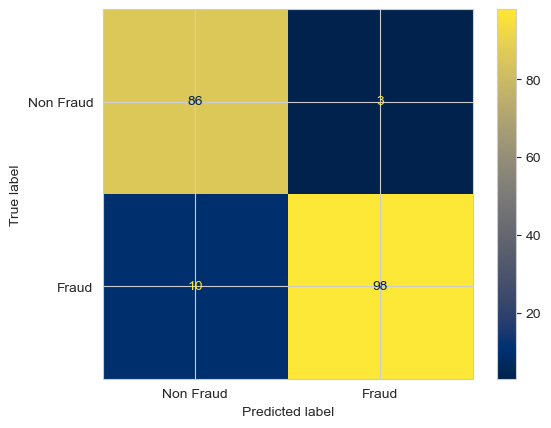

In [13]:
ConfusionMatrixDisplay.from_predictions(
    y_test, preds,
    display_labels=['Non Fraud', 'Fraud'],
    cmap='cividis'
)

From these results, the model appears to be able to correctly classify records with a relatively low false positive rate.

### Oversampling

Since the data is very limited, another approach is to oversample the dataset. Again, due to the unbalanced labels, random upsampling would not work well. Instead, we apply the [Synthetic Minority Over-sampling Technique (SMOTE)](https://dl.acm.org/doi/10.5555/1622407.1622416) as implemented in Imbalanced-Learn. We oversample the training sets only to avoid contaminating the testing set.

In [14]:
x_train, x_test, y_train, y_test = data_preparation(records)

sm = SMOTE(
    #sampling_strategy={0: 1_000_000, 1: 1_000_000}
)
x_train, y_train = sm.fit_resample(x_train, y_train)

print(x_train.shape)
print(y_train.shape)

(454904, 29)
(454904,)


This allows us to use the function `predicion_model` to construct a classifier using the SMOTE-upsampled training dataset and to generate appropriate predictions from the testing data.

In [15]:
preds = prediction_model(x_train, x_test, y_train, y_test)

(454904, 29) (56962, 29)


As above, we can gather the test labels back to the root node and produce a confusion matrix.

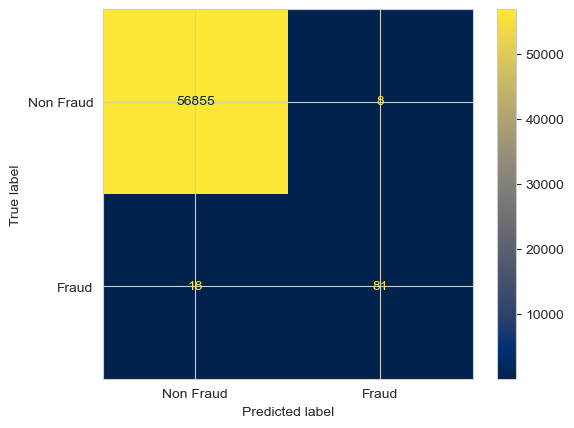

In [16]:
ConfusionMatrixDisplay.from_predictions(
    y_test, preds,
    display_labels=['Non Fraud', 'Fraud'],
    cmap='cividis'
)

The entries in this confusion matrix are smaller in a relative sense because we used more data to build this model. As always, these metrics suggest how a model will generalize when faced with new data.